# Restructured version of  initial development based on pylisa's apci_20_varying_workshop-based notebook

This notebook follows initial-dev-from-pylisa, but with code restructured into the module core.

The initial-dev-from-pylisa is based on apci_20_varying_workshop-based in pylisa, which was already a work in progress toward a refresh of some of the core aPCI functionality with connection to contemporary LISAinstrument and other tools.  It had already lost dependence on most of the pylisa code in favor of a new version inder development in the notebook.  This notebook brings that development here.

We are working toward a new simpler and better structured version of this which is suitable for generalizing to longer data sets.  The prior versions of this notebook are already very memory intensive and mixed up with the simulation processes and the TDI analysis. We hope to separate and distinguish these parts better, using code structures that facilitate throwing away large objects as soon as they are no longer needed. 

Note that the basic 6 channel input data at 4Hz sampling should be $6*4*8=192$ bytes per simulations second for about 16MB per simulation day.  The aPCI datamatrix, though may be hundreds of times larger!

## 0. Necessary installations

Installation of the LISA Simulation suite is required, just like in the workshop:

    pip install numpy scipy sympy h5py matplotlib xarray h5py scikit-learn
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/constants.git@latest
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/instrument.git@latest
    pip install git+https://gitlab.in2p3.fr/lisa-simulation/gw-response.git@latest
    pip install pytdi
    pip install backgrounds

In [1]:
import importlib
#importlib.reload(pytdi)
import numpy as np
import copy
from scipy import signal, constants, interpolate
from matplotlib import pyplot as plt
import h5py
# Instrument
#from lisainstrument import Instrument
#from lisainstrument.containers import ForEachSC
#from lisainstrument.containers import ForEachMOSA
# TDI
#from pytdi.michelson import X1, Y1, Z1, X2, Y2, Z2
from pytdi.intervar import ETA_SET
from pytdi import Data
# PCI
#from pylisa import covariance, apci, plotting, sensitivity, eigen
from pcipy import plotting, pci_filter, channel_analysis 
from sklearn.decomposition import PCA
# FTT modules
import pyfftw
from pyfftw.interfaces.numpy_fft import fft, ifft
pyfftw.interfaces.cache.enable()
!free

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324      585452    13363712        1276     1962160    15014448
Swap:             0           0           0


In [2]:
# Choose orbit file
# orbits = "/Users/qb265383/Codes/instrument/tests/keplerian-orbits.h5"
# orbits = "/pbs/home/q/qbaghi/codes/instrument/tests/keplerian-orbits.h5"
# orbits = "/work/SC/lisa/baghiq/orbits/keplerian-orbits.h5"
datadir = "/data/jgbaker/software/pylisa/data/"
orbits = datadir+"keplerian-orbits.h5"
workdir = datadir+"/simulations/"
dtpath = "2024-04-10_18h14_"
skip_hours=6

In [3]:
def build_data_vector(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full


In [4]:
# If we use a file
simpath = workdir + dtpath + 'measurements_4Hz.h5'
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# load data
data_noise = Data.from_instrument(simpath)


fs = data_noise.fs
skip = int(skip_hours * 3600 * fs)  #We skip the earliest part of the sim which is not representative

y_full = build_data_vector(data_noise, skip=skip)

# Get secondary noises
# sec_file = "/work/SC/lisa/baghiq/pci/simulations/23-05-2022_10h10_noise_sec_4Hz.h5"
# sec_file = datadir+'/simulations/2024-29-07_18h06_noise_sec_4Hz.h5'

secpath = workdir + dtpath + 'noise_sec_4Hz.h5'

data_sec = Data.from_instrument(simpath)
    
y_sec = build_data_vector(data_sec, skip=skip, dtype=np.float64)

#######

central_freq = sim.attrs['central_freq']
dt = sim.attrs['dt']
n_data = sim.attrs['size']

You are using a measurement file in a version that might not be fully supported
You are using a measurement file in a version that might not be fully supported


In [5]:
# TDI2 fractional delay Lagrange interpolating polynomials are of order 31=1+15*2
# Overall TDI delays are up to 8x single link delay = 8.34 s * 4 Hz * 8 = about 267 sample
# Add 15 on each end: 267 + 2*15 = 297   
# TDI2 overall stencil is then about 297 samples
# aPCI overall stencil width is 1 + nhalf*2
nhalf = 45
# Us 12 hours data
ns = int(3 * 3600 * fs)
window = np.ones(ns)

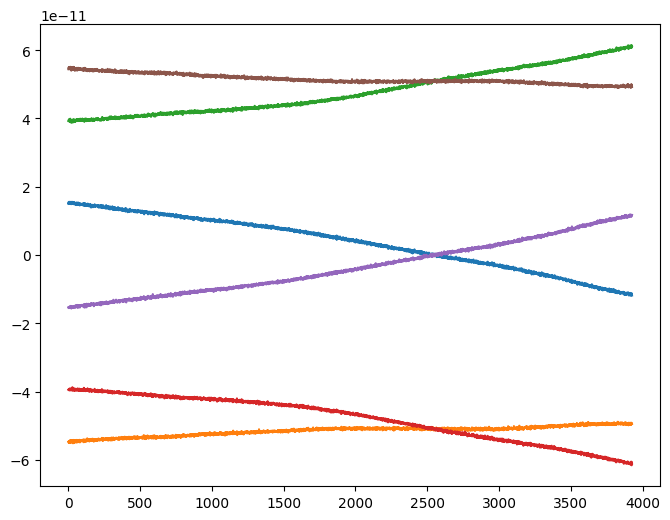

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     1377972    12274224        1276     2259128    14221620
Swap:             0           0           0


In [6]:
# Check time series
maxshow=4000
ev=ns//maxshow+1
_, axes = plt.subplots(1, 1, figsize=(8, 6))
for ich in range(len(y_full.T)):
    axes.plot(y_full[skip:skip+ns:ev, ich])
plt.show()
!free

In [7]:
import importlib
Tscale=10
importlib.reload(pci_filter)
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, sort_by_rms=False,Tscale=Tscale)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


shape in build datamatrix (43200, 546)
(43200, 546)
datamatrix mean -1.750962303172803e-14
(43200, 546)
variance check rms: 6.038447011287023e-09
shapes of chans, cov, components: (10, 43200) (10, 10) (10, 546)
[1.         1.         1.         1.         1.         1.
 1.         1.         1.00000001 1.        ]
channel covariance diagonality test on 10 components: 1.101834729362926e-09
component diagonality test on 10 components: 2.6940235193004264e-16
(43200, 546) (10, 546)
channels shape (10, 43200)
channel means [-1.47132724e-18 -5.25354011e-19  9.31162909e-19 -5.30966195e-19
  1.94863570e-19  2.57006494e-20  1.73501769e-19  1.63394980e-19
  6.62041582e-20  2.03661332e-19]
channel variances: [2.81263339e-38 3.52126961e-38 5.94114861e-38 1.91225784e-37
 2.37624508e-37 2.48291247e-37 5.05739028e-37 6.63534967e-37
 7.95348294e-37 1.02506044e-36 1.08835420e-36]
shape in build datamatrix (43200, 1092)
(43200, 1092)
datamatrix mean -9.11635678476169e-15
(43200, 1092)
variance check rms

In [8]:
import importlib
importlib.reload(pci_filter)
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list_rs = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, sort_by_rms=True,Tscale=Tscale)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


shape in build datamatrix (43200, 546)
(43200, 546)
datamatrix mean -1.750962303172803e-14
(43200, 546)
variance check rms: 6.038447011287023e-09
shapes of chans, cov, components: (10, 43200) (10, 10) (10, 546)
[1.         1.         1.         1.         1.         1.
 1.         1.00000001 1.         1.        ]
channel covariance diagonality test on 10 components: 1.2138027692225133e-09
component diagonality test on 10 components: 2.819738220801308e-16
(43200, 546) (10, 546)
channels shape (10, 43200)
channel means [ 2.57006494e-20  1.94863570e-19 -5.25354011e-19 -5.30966195e-19
  1.73501769e-19  1.63394980e-19  6.62041582e-20  9.31162909e-19
  2.03661332e-19  2.92314253e-19]
channel variances: [2.48291247e-37 2.37624508e-37 3.52126961e-38 1.91225784e-37
 5.05739028e-37 6.63534967e-37 7.95348294e-37 5.94114861e-38
 1.02506044e-36 1.08835420e-36 1.32657412e-36]
shape in build datamatrix (43200, 1092)
(43200, 1092)
datamatrix mean -9.11635678476169e-15
(43200, 1092)
variance check rms

In [9]:
importlib.reload(pci_filter)
pca_list_zm = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, zero_mean=True, Tscale=Tscale)            
            for q in range(3)]


ys (6, 43290)
means [ 3.42999737e-11 -5.07314973e-11  1.63789095e-11 -1.64111356e-11
 -3.43450729e-11  5.07036379e-11]
new means [ 2.98083104e-27 -5.35020955e-27  1.22290504e-27 -1.52863130e-27
  5.19734642e-27 -2.44581008e-27]
shape in build datamatrix (43200, 546)
(43200, 546)
datamatrix mean 2.118092138786644e-17
(43200, 546)
variance check rms: 5.591474586743227e-10
shapes of chans, cov, components: (10, 43200) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 3.3827422396361157e-10
component diagonality test on 10 components: 3.6536565814839204e-16
(43200, 546) (10, 546)
channels shape (10, 43200)
channel means [-4.99647446e-14 -2.26002945e-14  3.72542691e-14 -1.86403093e-14
  4.48248699e-15  1.28668994e-15  6.75329666e-15  4.83314915e-15
  1.48047199e-15  6.72212566e-15]
channel variances: [2.81263339e-38 3.52126961e-38 5.94114861e-38 1.91225784e-37
 2.37624508e-37 2.48291247e-37 5.05739028e-37 6.63534967e-37
 7.95348294e-37 

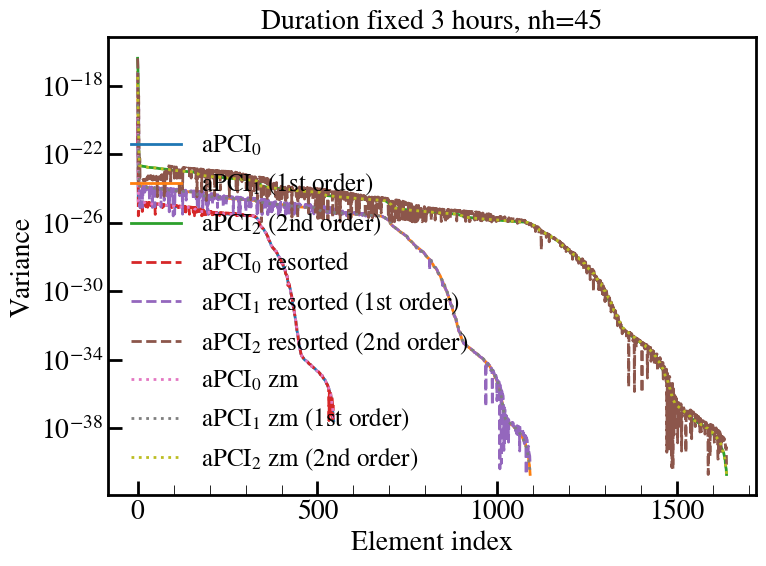

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     1572412    12076272        1276     2262640    14027180
Swap:             0           0           0
[ 0.00000000e+00  0.00000000e+00  2.29588740e-41  0.00000000e+00
  4.59177481e-41  1.37753244e-40  1.83670992e-40 -6.88766221e-41
 -6.88766221e-41  0.00000000e+00  6.88766221e-41  2.06629866e-40
  2.75506488e-40  0.00000000e+00 -3.21424237e-40  1.14794370e-40
  1.37753244e-40 -2.29588740e-41 -9.18354962e-41  9.18354962e-41
 -1.37753244e-40 -1.83670992e-40  1.37753244e-40  4.59177481e-41
  2.29588740e-41  4.59177481e-41  0.00000000e+00 -1.60712118e-40
  0.00000000e+00  1.37753244e-40  1.83670992e-40  2.29588740e-41
  0.00000000e+00  9.18354962e-41  0.00000000e+00  6.88766221e-41
  1.3775

In [10]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

ax1.plot(pca_list[0].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_0$',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[1].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_1$ (1st order)',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[2].explained_variance,
            #linestyle='dashed',
            label=r'aPCI$_2$ (2nd order)',
            linewidth=2,
            rasterized=False)

if True:
    ax1.plot(pca_list_rs[0].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_0$ resorted',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[1].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_1$ resorted (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[2].explained_variance,
                linestyle='dashed',
                label=r'aPCI$_2$ resorted (2nd order)',
                linewidth=2,
                rasterized=False)

if True:
    ax1.plot(pca_list_zm[0].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_0$ zm',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[1].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_1$ zm (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[2].explained_variance,
                linestyle='dotted',
                label=r'aPCI$_2$ zm (2nd order)',
                linewidth=2,
                rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Element index", fontsize=20)
ax1.set_ylabel("Variance", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='lower left', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free
for i in range(3):
    print(pca_list[i].explained_variance-pca_list_zm[i].explained_variance)

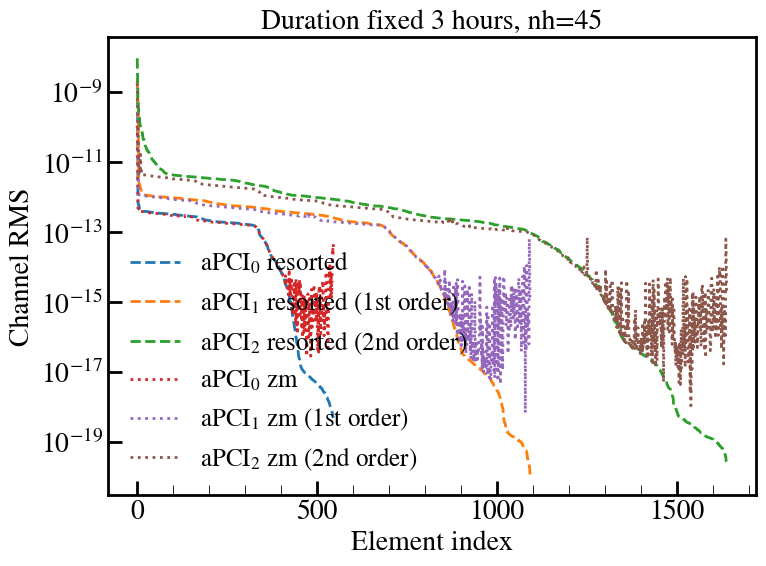

/bin/bash: /data/spack/opt/spack/linux-ubuntu20.04-skylake_avx512/gcc-9.4.0/anaconda3-2021.05-ch4zgln24uzwnqh2elmcfs6dkfuevuey/lib/libtinfo.so.6: no version information available (required by /bin/bash)
              total        used        free      shared  buff/cache   available
Mem:       15911324     1575088    12073464        1276     2262772    14024488
Swap:             0           0           0
[ 0.00000000e+00  0.00000000e+00  2.29588740e-41  0.00000000e+00
  4.59177481e-41  1.37753244e-40  1.83670992e-40 -6.88766221e-41
 -6.88766221e-41  0.00000000e+00  6.88766221e-41  2.06629866e-40
  2.75506488e-40  0.00000000e+00 -3.21424237e-40  1.14794370e-40
  1.37753244e-40 -2.29588740e-41 -9.18354962e-41  9.18354962e-41
 -1.37753244e-40 -1.83670992e-40  1.37753244e-40  4.59177481e-41
  2.29588740e-41  4.59177481e-41  0.00000000e+00 -1.60712118e-40
  0.00000000e+00  1.37753244e-40  1.83670992e-40  2.29588740e-41
  0.00000000e+00  9.18354962e-41  0.00000000e+00  6.88766221e-41
  1.3775

In [11]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

if False:
    ax1.plot(pca_list[0].explained_rms, 
                #linestyle='dashed',
                label=r'aPCI$_0$',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list[1].explained_rms, 
                #linestyle='dashed',
                label=r'aPCI$_1$ (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list[2].explained_rms,
                #linestyle='dashed',
                label=r'aPCI$_2$ (2nd order)',
                linewidth=2,
                rasterized=False)

if True:
    ax1.plot(pca_list_rs[0].explained_rms, 
                linestyle='dashed',
                label=r'aPCI$_0$ resorted',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[1].explained_rms, 
                linestyle='dashed',
                label=r'aPCI$_1$ resorted (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[2].explained_rms,
                linestyle='dashed',
                label=r'aPCI$_2$ resorted (2nd order)',
                linewidth=2,
                rasterized=False)

if True:
    ax1.plot(pca_list_zm[0].explained_rms, 
                linestyle='dotted',
                label=r'aPCI$_0$ zm',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[1].explained_rms, 
                linestyle='dotted',
                label=r'aPCI$_1$ zm (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[2].explained_rms,
                linestyle='dotted',
                label=r'aPCI$_2$ zm (2nd order)',
                linewidth=2,
                rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Element index", fontsize=20)
ax1.set_ylabel("Channel RMS", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='lower left', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free
for i in range(3):
    print(pca_list[i].explained_variance-pca_list_zm[i].explained_variance)

i= 0
shape in build datamatrix (43200, 1092)
mean: -8.189151922806432e-21
variance:  7.575894069956684e-41
mean: -1.2171389498058263e-20
variance:  2.384570422159414e-40
mean: -1.1982032320926103e-20
variance:  2.9748485952704305e-40
mean: 1.774551410675084e-20
variance:  3.8238218947512795e-40
i= 1
shape in build datamatrix (43200, 1638)
mean: 2.6303359889966762e-20
variance:  7.491131262082566e-41
mean: 3.3511061831250436e-21
variance:  8.094462390311446e-40
mean: -2.7776319567224154e-20
variance:  6.602972397371226e-40
mean: -2.5493476712805015e-20
variance:  9.005097655597496e-40


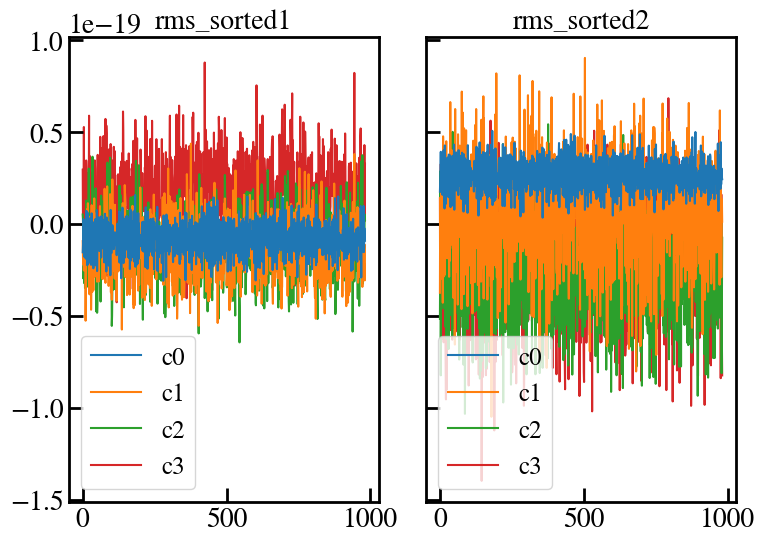

shape in build datamatrix (43200, 1092)
unstacked data mtrix shape (43200, 2, 546)
comps shape (4, 1092)
comps reshaped (4, 2, 546)
shape in build datamatrix (43200, 1638)
unstacked data mtrix shape (43200, 3, 546)
comps shape (4, 1638)
comps reshaped (4, 3, 546)


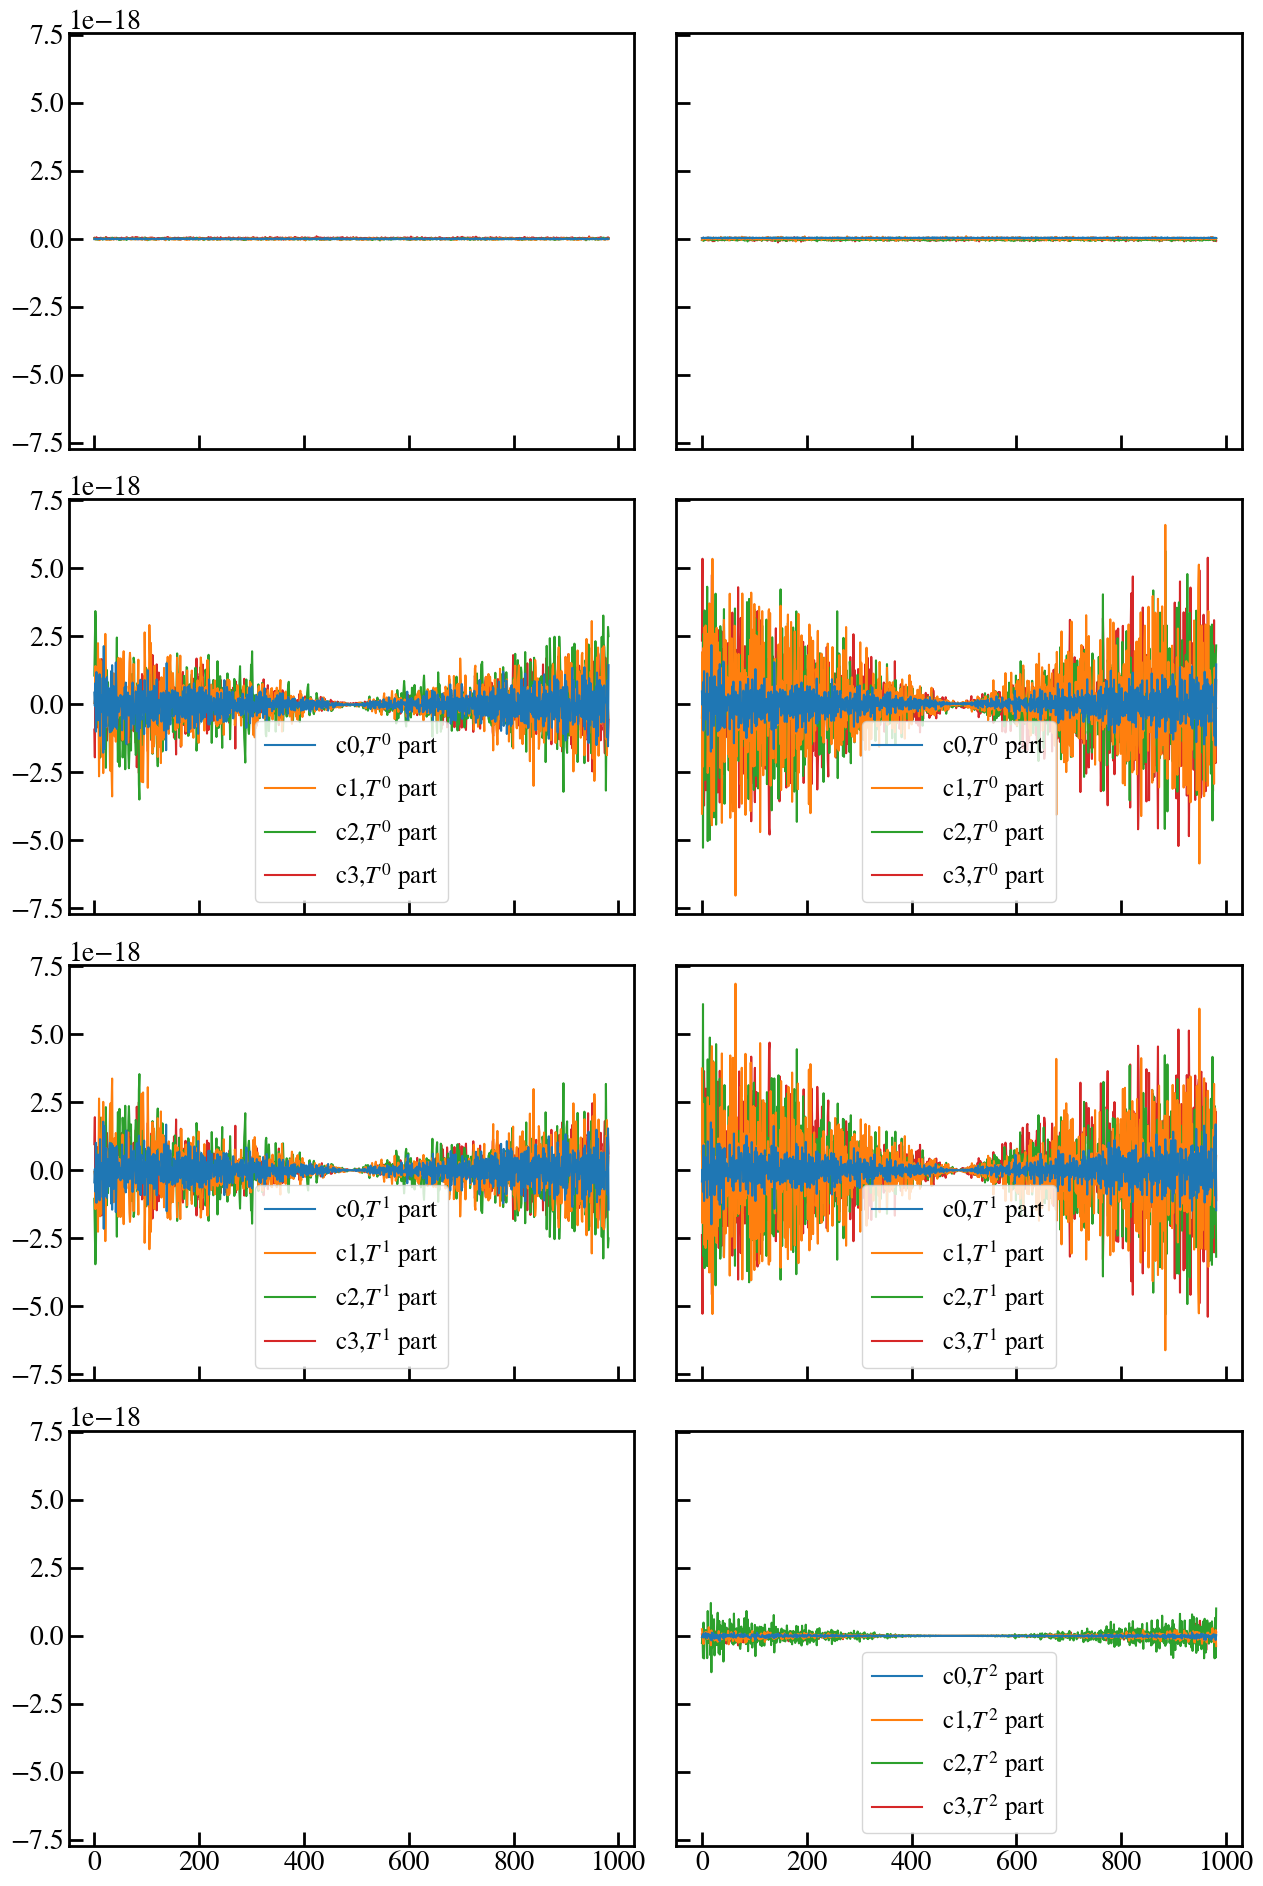

In [12]:
importlib.reload(channel_analysis)
order=2
ev=100
#x=np.array(pca_list[order].apply_for_channels_split_orders(y_full[:ns+2*nhalf, :].T, n_channels=1))
#channel_analysis.stationarity_plots([pca_list[order],pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=4,split_orders=True,title=['standard','zero_mean','rms_sorted'])
#channel_analysis.stationarity_plots([pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=1,split_orders=True,title=['zero_mean','rms_sorted'])
channel_analysis.stationarity_plots([pca_list_rs[order-1],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=4,split_orders=True,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])

i= 0
shape in build datamatrix (43200, 1092)
plotting 6 of 6 channels
subtracting bin means!
43 batches of size 1000
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
i= 1
shape in build datamatrix (43200, 1638)
plotting 6 of 6 channels
subtracting bin means!
43 batches of size 1000
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)
stdevs shape (6, 43) ev 1
(43,)


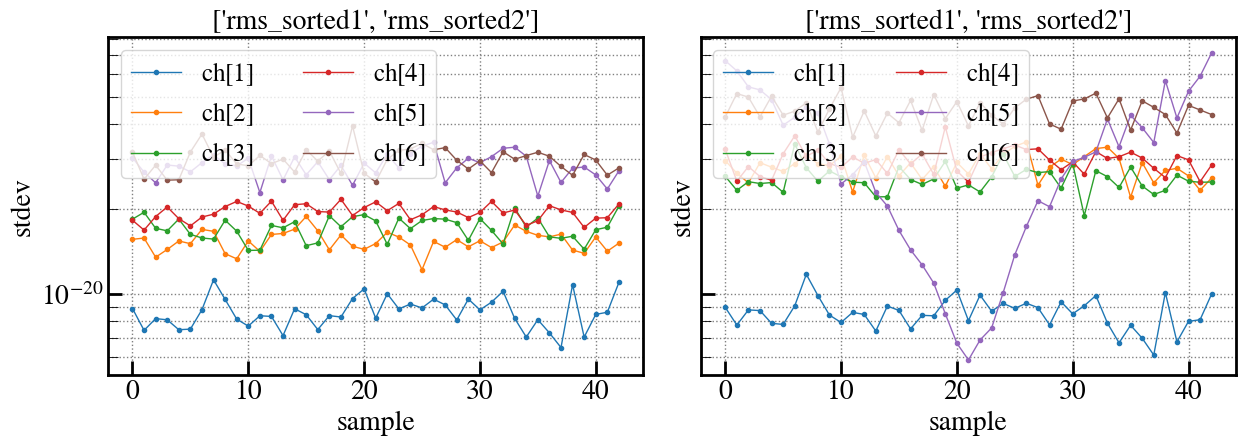

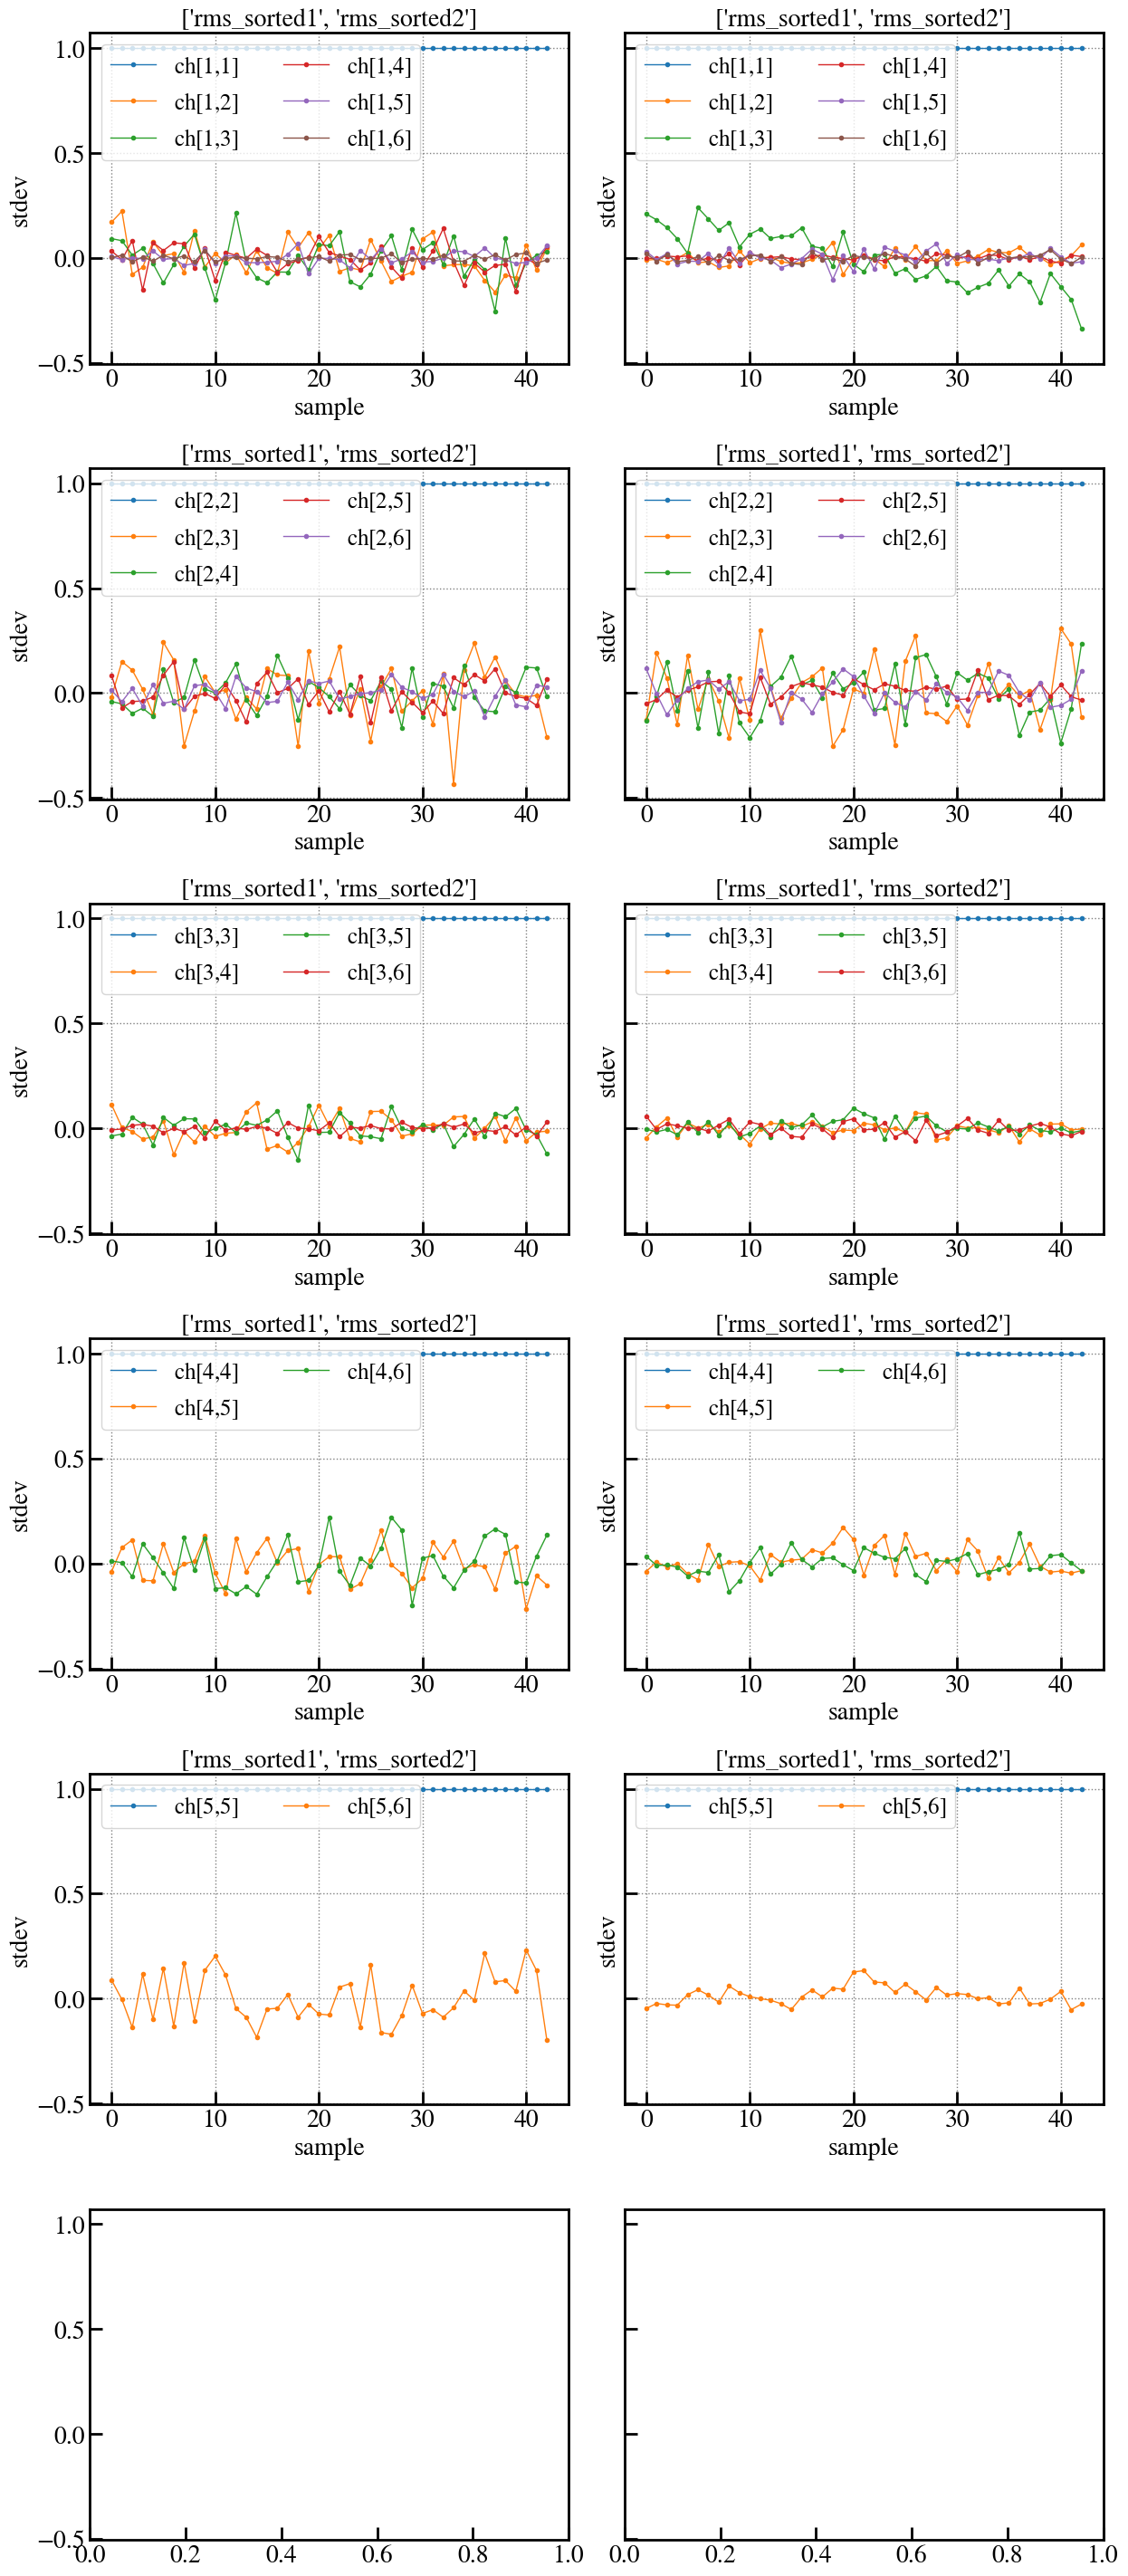

In [13]:
importlib.reload(channel_analysis)
order=2
ev=100
#x=np.array(pca_list[order].apply_for_channels_split_orders(y_full[:ns+2*nhalf, :].T, n_channels=1))
#channel_analysis.stationarity_plots([pca_list[order],pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=4,split_orders=True,title=['standard','zero_mean','rms_sorted'])
#channel_analysis.temporal_variance_corr_plots([pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=3,split_orders=True,title=['zero_mean','rms_sorted'])
channel_analysis.temporal_variance_corr_plots([pca_list_rs[order-1],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=6,split_orders=True,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])